<a href="https://colab.research.google.com/github/aniruddh-alt/AppleStockForecast_LSTM/blob/main/StockForecast_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
torch.manual_seed(42)

In [3]:
import yfinance as yf
### downloading Apple Stock data from yahoo finance from 2010 till present.
data = yf.download("AAPL", start='2010-01-01')

[*********************100%%**********************]  1 of 1 completed


In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454505,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465663,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362820,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.351056,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.393282,447610800
...,...,...,...,...,...,...
2024-08-13,219.009995,221.889999,219.009995,221.270004,221.270004,44155300
2024-08-14,220.570007,223.029999,219.699997,221.720001,221.720001,41960600
2024-08-15,224.600006,225.350006,222.759995,224.720001,224.720001,46414000


In [5]:
# Date is the index
features = ['Adj Close']
data = data[features]
data.head()

,Adj Close
Date,
2010-01-04,6.454505
2010-01-05,6.465663
2010-01-06,6.362820
2010-01-07,6.351056
2010-01-08,6.393282


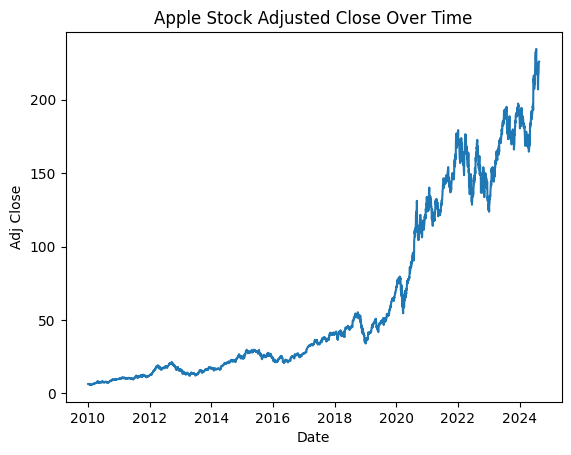

In [6]:
plt.plot(data.index ,data['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('Apple Stock Adjusted Close Over Time')
plt.show()


In [7]:
def windowed_dataset(data, window_size):
  df = data.copy()

  for i in range(window_size, 0, -1):
    df['Adj_Close t-'+str(i)] = df['Adj Close'].shift(i)

  df['Target'] = df['Adj Close']
  df.dropna(inplace=True)
  df.drop('Adj Close', axis=1, inplace=True)

  return df

In [8]:
df = windowed_dataset(data, window_size=5)
df

,Adj_Close t-5,Adj_Close t-4,Adj_Close t-3,Adj_Close t-2,Adj_Close t-1,Target
Date,,,,,,
2010-01-11,6.454505,6.465663,6.362820,6.351056,6.393282,6.336883
2010-01-12,6.465663,6.362820,6.351056,6.393282,6.336883,6.264801
2010-01-13,6.362820,6.351056,6.393282,6.336883,6.264801,6.353168
2010-01-14,6.351056,6.393282,6.336883,6.264801,6.353168,6.316373
2010-01-15,6.393282,6.336883,6.264801,6.353168,6.316373,6.210814
...,...,...,...,...,...,...
2024-08-13,206.990402,209.577423,213.063385,215.990005,217.529999,221.270004
2024-08-14,209.577423,213.063385,215.990005,217.529999,221.270004,221.720001
2024-08-15,213.063385,215.990005,217.529999,221.270004,221.720001,224.720001


In [9]:
X = df.drop('Target', axis=1)
y = df['Target']

### train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### scaling
# We will be fitting the feature scaler and target scaler with the train data.
# Then transform the train test data later so that the scaling remains consistent.

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

feature_scaler.fit(X_train)
target_scaler.fit(y_train.values.reshape(-1, 1))

MinMaxScaler()

In [10]:
### create a time series dataset object
# we will be inhereting the DataSet object from pytorch and implement __init__, __getitem__ and __len__

class myTimeSeriesDataset(Dataset):
  def __init__(self, X, y, feature_scaler, target_scaler):
    X = feature_scaler.transform(X)
    y = target_scaler.transform(y.values.reshape(-1, 1))
    self.X = torch.tensor(X[..., np.newaxis]).float()
    self.y = torch.tensor(y).float()

  def __getitem__(self, index):
    return (self.X[index], self.y[index])

  def __len__(self):
    return len(self.y)


In [11]:
train_data = myTimeSeriesDataset(X_train, y_train, feature_scaler, target_scaler)
test_data = myTimeSeriesDataset(X_test, y_test, feature_scaler, target_scaler)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [12]:
print(f'Train loader length: {len(train_loader)}')
print(f'Test loader length: {len(test_loader)}')

Train loader length: 92
Test loader length: 23


In [13]:
class LSTM_Model(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(LSTM_Model, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.input_size = input_size
    self.output_size = output_size

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, X):
    out, _ = self.lstm(X)
    out = self.fc(out[:, -1, :])
    return out

In [14]:
### early stopping object for training the model and stopping if there is no imporvement in the loss after a certain patientce threshold.
import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.restore_best_weights = restore_best_weights
        self.best_model = None

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())

        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())

        elif self.best_loss - val_loss <= self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                self.early_stop = True
                return True

        return False

In [23]:
### create a trainer object that trains and evaluates the LSTM model

class Trainer:
  def __init__(self, model, optimizer, criterion, train_loader, val_loader, early_stopping, device, max_epochs):
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.early_stopping = early_stopping
    self.device = device
    self.max_epochs = max_epochs
    self.history = {'train_loss': [], 'val_loss': []}

  def train(self):
    best_val_loss = float('inf')
    best_epoch = 0

    train_losses = []
    val_losses = []

    for epoch in range(self.max_epochs):
      self.model.train()
      running_loss = 0
      for batch_index, (x, y) in enumerate(self.train_loader):
        X = x.to(self.device)
        y = y.to(self.device)

        self.optimizer.zero_grad()
        y_pred = self.model(X)
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()

        running_loss += loss.item()
      train_loss = running_loss / len(self.train_loader)
      train_losses.append(train_loss)

      val_loss = self.evaluate()
      val_losses.append(val_loss)

      if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{self.max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1

      if self.early_stopping(self.model, val_loss):
        print('Best Epoch: ', epoch)
        break

    print('Training Finished')
    self.history['train_loss'] = train_losses
    self.history['val_loss'] = val_losses



  @torch.no_grad()
  def evaluate(self):
    best_val_loss = float('inf')
    best_epoch = 0

    for epoch in range(self.max_epochs):
      self.model.train()
      running_loss = 0
      for batch_index, (x, y) in enumerate(self.val_loader):
        X = x.to(self.device)
        y = y.to(self.device)
        y_pred = self.model(X)
        loss = self.criterion(y_pred, y)
        running_loss += loss.item()
      val_loss = running_loss / len(self.val_loader)

    return val_loss




In [24]:
class Config:
  input_size = 1
  hidden_size = 64
  output_size = 1
  num_layers = 2
  device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

Config.device

device(type='cuda', index=0)

In [25]:
model = LSTM_Model(Config.input_size, Config.hidden_size, Config.output_size, Config.num_layers)
model.to(Config.device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-6, weight_decay = 0.01)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)

print(model)

LSTM_Model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [26]:
trainer = Trainer(model, optimizer, criterion, train_loader, test_loader, early_stopper, Config.device, max_epochs = 300)

In [27]:
trainer.train()

Epoch: 10/300, Train Loss: 0.1735, Val Loss: 0.1725
Epoch: 20/300, Train Loss: 0.1508, Val Loss: 0.1502
Epoch: 30/300, Train Loss: 0.1286, Val Loss: 0.1284
Epoch: 40/300, Train Loss: 0.1073, Val Loss: 0.1075
Epoch: 50/300, Train Loss: 0.0882, Val Loss: 0.0891
Epoch: 60/300, Train Loss: 0.0736, Val Loss: 0.0751
Epoch: 70/300, Train Loss: 0.0649, Val Loss: 0.0671
Epoch: 80/300, Train Loss: 0.0607, Val Loss: 0.0631
Epoch: 90/300, Train Loss: 0.0578, Val Loss: 0.0601
Epoch: 100/300, Train Loss: 0.0547, Val Loss: 0.0569
Epoch: 110/300, Train Loss: 0.0512, Val Loss: 0.0533
Epoch: 120/300, Train Loss: 0.0473, Val Loss: 0.0492
Epoch: 130/300, Train Loss: 0.0430, Val Loss: 0.0446
Epoch: 140/300, Train Loss: 0.0381, Val Loss: 0.0395
Epoch: 150/300, Train Loss: 0.0328, Val Loss: 0.0340
Epoch: 160/300, Train Loss: 0.0271, Val Loss: 0.0280
Epoch: 170/300, Train Loss: 0.0212, Val Loss: 0.0218
Epoch: 180/300, Train Loss: 0.0153, Val Loss: 0.0156
Epoch: 190/300, Train Loss: 0.0098, Val Loss: 0.0100
Ep

In [28]:
trainer.evaluate()

0.0007529315012304679

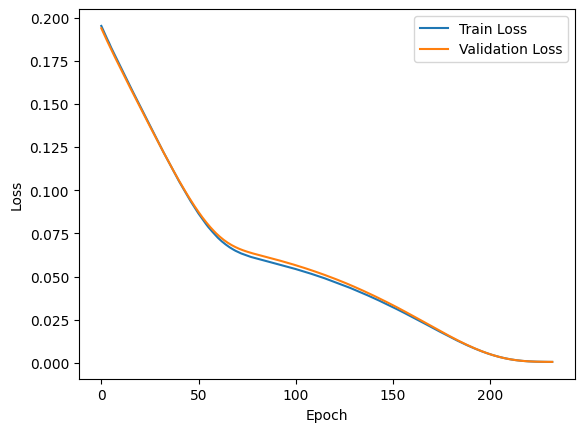

In [30]:
history = trainer.history
train_loss = history['train_loss']
val_loss = history['val_loss']

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
preds = []
truths = []

# Helper function to convert tensors to numpy arrays
torch_to_numpy = lambda x: x.detach().cpu().numpy()


preds = []
truths = []
with torch.no_grad():
    for in_data, out_data in test_data:
        # Add inputs to device
        in_data = in_data.to(Config.device)

        # Forward pass
        output = model(in_data.unsqueeze(0))

        # Convert tensors to numpy arrays
        truth = torch_to_numpy(out_data)
        pred = torch_to_numpy(output)

        # Reshape to 2D for inverse transform
        truth_reshaped = truth.reshape(-1, 1)
        pred_reshaped = pred.reshape(-1, 1)

        # Append transformed data
        truths.append(target_scaler.inverse_transform(truth_reshaped))
        preds.append(target_scaler.inverse_transform(pred_reshaped))

# Flatten and concatenate all arrays
truths = np.concatenate([np.array(x).flatten() for x in truths])
preds = np.concatenate([np.array(x).flatten() for x in preds])

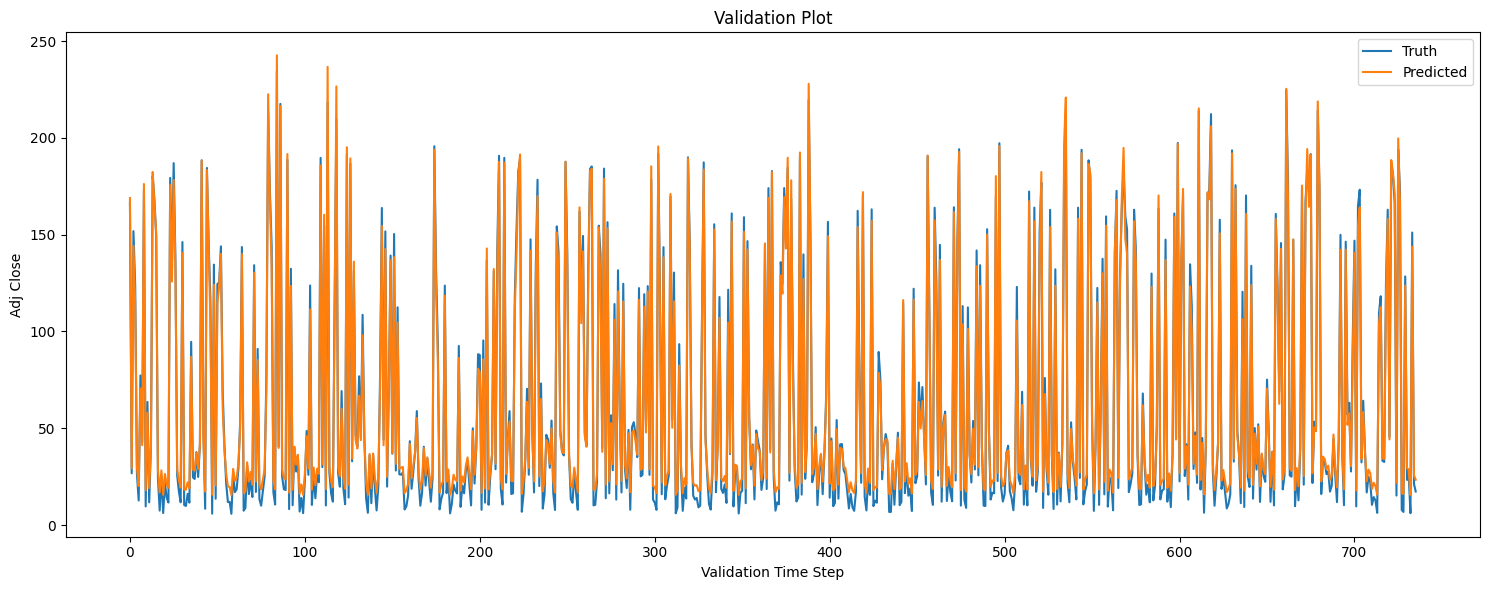

In [44]:
plt.figure(figsize=(15, 6))
plt.plot(truths, label="Truth")
plt.plot(preds, label="Predicted")
plt.legend()

plt.ylabel("Adj Close")
plt.xlabel("Validation Time Step")
plt.title("Validation Plot")
plt.tight_layout()
plt.show()

In [45]:
metrics = {
    'MSE': mean_squared_error(truths, preds),
    'RMSE': np.sqrt(mean_squared_error(truths, preds)),
    'R2': r2_score(truths, preds)
}

metrics

{'MSE': 39.256012, 'RMSE': 6.265462, 'R2': 0.9898061222886967}